In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
stop = stopwords.words('english')

# Reading data in a dataframe

In [5]:
#Reading data to a pandas dataframe
df=pd.read_csv("C:/Users/Public/Output/adult_notes/adult_notes.csv")

In [ ]:
#converting from object to string
df['chartext'] = df['chartext'].astype(str)

# Tokenization using NTLK and removing punctuation

In [8]:

#Tokenize and remove punctuation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['chartext'] = df.apply(lambda row: tokenizer.tokenize(str(row['chartext'])), axis=1)


In [14]:
#converting from object to string
df['chartext'] = df['chartext'].astype(str)
#df['chartext'] =df['chartext'].apply(lambda x: [item for item in x if item.lower() not in stop and not item.isdigit()])

# Splitting the dataframe into test and train set

In [44]:
df_test = df.loc[df['train'] == 0]
df_train = df.loc[df['train'] == 1]
x_train=df_train['chartext']
y_train=df_train['mort_icu'] 
x_test=df_test['chartext']
y_test=df_test['mort_icu']

# TF-IDF to transform bag-of-word counts into numerical features 

In [68]:
#TDIDF on train data and removing stopwords
vectorizer = TfidfVectorizer(lowercase=True,analyzer='word',token_pattern='[A-Za-z]+',stop_words= 'english',ngram_range=(1,1))
train_vect = vectorizer.fit_transform(df_train['chartext'])
train_vect

<19166x105220 sparse matrix of type '<class 'numpy.float64'>'
	with 9647858 stored elements in Compressed Sparse Row format>

In [69]:
#TDIDF on test data x_test.apply(lambda x: np.str_(x))
test_vect = vectorizer.transform(x_test)

# Training logistic regression model

In [70]:
#Regression model
logreg = LogisticRegression(penalty='l1',max_iter=5000)
logreg.fit(train_vect,y_train)

C:\Users\manis\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Predicting using the trained model 

In [71]:
y_pred=logreg.predict(test_vect)

# Determine model performance (ROC and AUC score)

In [72]:
#Confusion Matrix 
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix


array([[7302,   67],
       [ 709,  104]], dtype=int64)

In [73]:
#Accuracy, Precision and recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9051576631630408
Precision: 0.6081871345029239
Recall: 0.12792127921279212


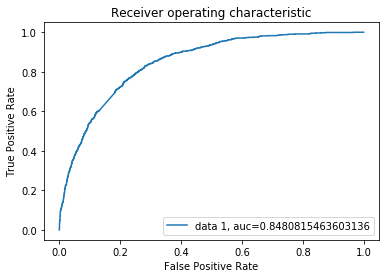

In [74]:
#ROC Curve
y_pred_proba = logreg.predict_proba(test_vect)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Determine top 5 and lowest 5 features

In [64]:
#top five factors
coefs=logreg.coef_[0]
top_five = np.argpartition(coefs, -5)[-5:]
top_five_sorted=top_five[np.argsort(coefs[top_five])]
print(top_five_sorted)

[171577  91906  81951  85111 140195]


In [65]:
print("Top 5 risk words: ")
print(np.array(vectorizer.get_feature_names())[top_five_sorted.astype(int)])

Top 5 risk words: 
['worsening' 'dnr' 'cmo' 'corneal' 'prognosis']


In [66]:
#lowest 5 factors
coefs=logreg.coef_[0]
bottom_five = np.argpartition(coefs, 5)[0:5]
bottom_five_sorted=bottom_five[np.argsort(coefs[bottom_five])]

In [67]:
print("Lowest 5 risk words: ")
print(np.array(vectorizer.get_feature_names())[bottom_five_sorted.astype(int)])

Lowest 5 risk words: 
['extubation' 'diet' 'clear' 'extubated' 'normal']


# Confirming top and lowest importance words using ensemble of trees

C:\Users\manis\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


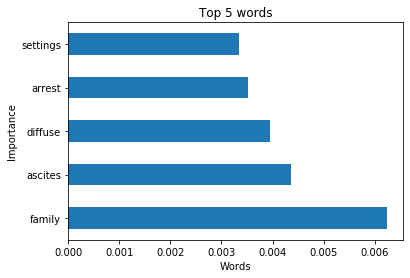

In [95]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(train_vect,y_train)
#print(model.feature_importances_); #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=vectorizer.get_feature_names());

#Lowest importance 5 features
feat_importances.nlargest(5).plot(kind='barh');
plt.xlabel('Words')
plt.ylabel('Importance')
plt.title('Top 5 words')
plt.show()


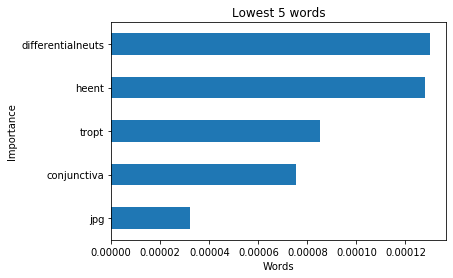

In [96]:
#Highest importance 5 features
feat_importances.nsmallest(5).plot(kind='barh')
plt.xlabel('Words')
plt.ylabel('Importance')
plt.title('Lowest 5 words')
plt.show()